# Creek

1. Blacken some cells of the grid resp. 
2. A number in a circle indicates how many of the 4 adjacent cells must be blackened.
3. All white cells must form a single orthogonally contiguous area.

-----

1. 将网格的某些单元格涂黑.
2. 圆圈中的数字表示 4 个相邻单元格中有多少个必须变黑。
3. 所有白细胞必须形成一个正交连续的区域。

In [2]:

import numpy as np
from ortools.sat.python import cp_model as cp
import gurobipy as gp
from collections import deque
from itertools import chain

In [3]:
def readGrid(path):
    with open(f"../assets/data/creek/{path}.txt") as f:
        num = f.readline()
        m, n = num.split(" ")[0], num.split(" ")[1]
        grid = f.readlines()
        res = [g.strip().split(" ") for g in grid]
        return int(m), int(n), res

if __name__ == "__main__":
    m, n, grid = readGrid("7x7_1")
    for g in grid:
        print(g)

['.', '.', '2', '.', '1', '.', '.', '0']
['2', '3', '.', '.', '.', '2', '.', '1']
['.', '.', '1', '.', '3', '.', '.', '.']
['1', '.', '.', '1', '.', '1', '.', '1']
['.', '2', '1', '.', '2', '.', '2', '.']
['.', '.', '.', '1', '.', '2', '.', '.']
['2', '.', '2', '.', '2', '.', '.', '0']
['1', '2', '2', '1', '.', '.', '1', '0']


In [22]:
def CreekSolver(m, n, grid) :
    """_summary_

    Args:
        m (_type_): 行数
        n (_type_): 列数
        grid (_type_): 网格
    """
    
    Creek = gp.Model("Creek")
    Creek.modelSense = gp.GRB.MAXIMIZE
    Creek.Params.lazyConstraints = 1
    Creek.update()
    x = {}
    for i in range(m):
        for j in range(n):
            x[i, j] = Creek.addVar(
            vtype = gp.GRB.BINARY,
            obj = 1,
            name = f"x[{i},{j}]")
            
    for i in range(m + 1):
        for j in range(n + 1):
            if grid[i][j] != ".":
                neighbours = []
                directions = [(-1, -1), (-1, 0), (0, -1), (0, 0)]
                for (subx, suby) in directions:
                    if (i + subx >= 0 and i + subx < m) and (j + suby >= 0 and j + suby < n):
                        neighbours.append((i + subx, j + suby))
                Creek.addConstr(gp.quicksum(x[subx, suby] for (subx, suby) in neighbours) == int(grid[i][j]), name = f"constr_{i}_{j}_{grid[i][j]}")

    for i in range(m):
        for j in range(n):
            neighbours = []
            directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            for (subx, suby) in directions:
                if (i + subx >= 0 and i + subx < m) and (j + suby >= 0 and j + suby < n):
                    neighbours.append((i + subx, j + suby))
            Creek.addConstr(gp.quicksum(x[subx, suby] for (subx, suby) in neighbours) <= len(neighbours) - 1 + x[i, j], name = f"alone_{i}_{j}")
    
    Creek.setObjective(gp.quicksum(x[i, j] for i in range(m) for j in range(n)), gp.GRB.MAXIMIZE)
    # Creek.setObjective(10, gp.GRB.MAXIMIZE)
    # Creek.write("Creek.lp")
    def border_elim(model, where):
        if (where == gp.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            curr_grid = [[0] * n for i in range(m)]
            for i in range(m):
                for j in range(n):
                    if int(x_sol[i, j]) == 0:
                        curr_grid[i][j] = 1
                
            def find_surrounding_black_cells(grid):
                rows, cols = len(grid), len(grid[0])
                visited = set()
                directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right movements
                total_white = sum(chain.from_iterable(grid))
                # Find the first unvisited white cell
                def find_unvisited_white():
                    for i in range(rows):
                        for j in range(cols):
                            if grid[i][j] == 1 and (i, j) not in visited:
                                return (i, j)
                    return None
                borders_cut = [] # record cells that formulate the border: list(tuple)
                cells_inside_borders = [] # record all cells inside the border: list(tuple)
                cnt_white = 0
                while len(visited) < total_white:
                    start = find_unvisited_white()
                    if not start:
                        break
                    # Use BFS to find all connected white cells and record the surrounding black cells
                    queue = deque([start])
                    surrounding_black_cells = set()  # Use a set to avoid duplicates
                    current_inside_cells = [] # record cells in current border
                    while queue:
                        x, y = queue.popleft()
                        if (x, y) in visited:
                            continue
                        visited.add((x, y))
                        current_inside_cells.append((x, y))
                        cnt_white += 1
                        # Check all four adjacent directions
                        for dx, dy in directions:
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < rows and 0 <= ny < cols:
                                if grid[nx][ny] == 1 and (nx, ny) not in visited:
                                    queue.append((nx, ny))
                                elif grid[nx][ny] == 0:
                                    surrounding_black_cells.add((nx, ny))
                    borders_cut.append(list(surrounding_black_cells))
                    cells_inside_borders.append(current_inside_cells)
                    
                assert len(borders_cut) == len(cells_inside_borders)

                if cnt_white == sum(chain.from_iterable(grid)) and len(borders_cut) == 1:
                    return [], []
                # borders_cut.sort(key = lambda x: len(x), reverse = True)
                return borders_cut, cells_inside_borders

            borders_cut, cells_inside_borders = find_surrounding_black_cells(curr_grid)

            for borders, cells_inside in zip(borders_cut, cells_inside_borders):
                for (cell_x, cell_y) in cells_inside:
                    model.cbLazy(gp.quicksum(model._x[subx, suby] for (subx, suby) in borders ) <= len(borders) - 1 + model._x[cell_x, cell_y])
                    
                
    Creek._x = x
    Creek.optimize(border_elim)
    # Creek.computeIIS()
    # Creek.write("Creek.ilp")
    
    for i in range(m):
        for j in range(n):
            if x[i, j].x > 1e-6:
                print(f"X", end = " ")
            else:
                print(f".", end = " ")
        print()
    print()

    
if __name__ == "__main__":
    m, n, grid = readGrid("19x24_1")
    CreekSolver(m, n, grid)
    

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 710 rows, 456 columns and 3174 nonzeros
Model fingerprint: 0x0b2dfb2f
Variable types: 0 continuous, 456 integer (456 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 689 rows and 422 columns
Presolve time: 0.01s
Presolved: 21 rows, 34 columns, 56 nonzeros
Variable types: 0 continuous, 34 integer (34 binary)

Root relaxation: objective 2.230000e+02, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  223.00000    0    -          -  223.00000      -     -    0s
     0     0 

In [4]:
def CreekSolver(m, n, grid) :
    """_summary_

    Args:
        m (_type_): 行数
        n (_type_): 列数
        grid (_type_): 网格
    """
    
    Creek = gp.Model("Creek")
    Creek.modelSense = gp.GRB.MINIMIZE
    Creek.Params.lazyConstraints = 1
    Creek.update()
    x = {}
    for i in range(m):
        for j in range(n):
            x[i, j] = Creek.addVar(
            vtype = gp.GRB.BINARY,
            obj = 1,
            name = f"x[{i},{j}]")
            
    for i in range(m + 1):
        for j in range(n + 1):
            if grid[i][j] != ".":
                neighbours = []
                directions = [(-1, -1), (-1, 0), (0, -1), (0, 0)]
                for (subx, suby) in directions:
                    if (i + subx >= 0 and i + subx < m) and (j + suby >= 0 and j + suby < n):
                        neighbours.append((i + subx, j + suby))
                Creek.addConstr(gp.quicksum(x[subx, suby] for (subx, suby) in neighbours) == int(grid[i][j]), name = f"constr_{i}_{j}_{grid[i][j]}")

    for i in range(m):
        for j in range(n):
            neighbours = []
            directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            for (subx, suby) in directions:
                if (i + subx >= 0 and i + subx < m) and (j + suby >= 0 and j + suby < n):
                    neighbours.append((i + subx, j + suby))
            Creek.addConstr(gp.quicksum(x[subx, suby] for (subx, suby) in neighbours) <= len(neighbours) - 1 + x[i, j], name = f"alone_{i}_{j}")
    
    Creek.setObjective(gp.quicksum(x[i, j] for i in range(m) for j in range(n) ), gp.GRB.MINIMIZE)
    # Creek.setObjective(10, gp.GRB.MAXIMIZE)
    # Creek.write("Creek.lp")
    def border_elim(model, where):
        if (where == gp.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            curr_grid = [[0] * n for i in range(m)]
            for i in range(m):
                for j in range(n):
                    if int(x_sol[i, j]) == 0:
                        curr_grid[i][j] = 1

            def find_surrounding_black_cells_inside(grid, visited):
                rows, cols = len(grid), len(grid[0])
                directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right movements
                total_white = sum(chain.from_iterable(grid))
                def find_unvisited_white_inside():
                    for i in range(rows):
                        for j in range(cols):
                            if grid[i][j] == 1 and (i, j) not in visited:
                                return (i, j)
                    return []
                borders_cut = []
                cnt_white = 0
                while len(visited) < total_white:
                    start = find_unvisited_white_inside()
                    if not start:
                        break
                    queue = deque([start])
                    surrounding_black_cells = set()  # Use a set to avoid duplicates
                    # cnt_white = 0
                    while queue:
                        x, y = queue.popleft()
                        if (x, y) in visited:
                            continue
                        visited.add((x, y))
                        cnt_white += 1
                        # Check all four adjacent directions
                        for dx, dy in directions:
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < rows and 0 <= ny < cols:
                                if grid[nx][ny] == 1 and (nx, ny) not in visited:
                                    queue.append((nx, ny))
                                elif grid[nx][ny] == 0:
                                    surrounding_black_cells.add((nx, ny))
                    borders_cut.append(list(surrounding_black_cells))
                
                if sum(chain.from_iterable(grid)) == len(visited)  and len(borders_cut) == 1:
                    return []
                borders_cut.sort(key=lambda x: len(x))
                return borders_cut

                
            def find_surrounding_black_cells_from_border(grid):
                rows, cols = len(grid), len(grid[0])
                visited = set()
                directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right movements
                total_white = sum(chain.from_iterable(grid))
                # Find the first unvisited white cell
                def find_unvisited_white():
                    for i in range(rows):
                        if grid[i][0] == 1 and (i, 0) not in visited:
                            return (i, 0)
                    for i in range(rows):
                        if grid[i][cols - 1] == 1 and (i, cols - 1) not in visited:
                            return (i, cols - 1)
                    for j in range(cols):
                        if grid[0][j] == 1 and (0, j) not in visited:
                            return (0, j)
                    for j in range(cols):
                        if grid[rows - 1][j] == 1 and (rows - 1, j) not in visited:
                            return (rows - 1, j)
                    return None
                borders_cut = []
                cnt_white = 0
                while len(visited) < total_white:
                    start = find_unvisited_white()
                    if not start:
                        break
                    # Use BFS to find all connected white cells and record the surrounding black cells
                    queue = deque([start])
                    surrounding_black_cells = set()  # Use a set to avoid duplicates
                    # cnt_white = 0
                    while queue:
                        x, y = queue.popleft()
                        if (x, y) in visited:
                            continue
                        visited.add((x, y))
                        cnt_white += 1
                        # Check all four adjacent directions
                        for dx, dy in directions:
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < rows and 0 <= ny < cols:
                                if grid[nx][ny] == 1 and (nx, ny) not in visited:
                                    queue.append((nx, ny))
                                elif grid[nx][ny] == 0:
                                    surrounding_black_cells.add((nx, ny))
                    borders_cut.append(list(surrounding_black_cells))

                if cnt_white == sum(chain.from_iterable(grid)) and len(borders_cut) == 1:
                    return [], visited
                borders_cut.sort(key = lambda x: len(x), reverse = True)
                return borders_cut, visited
            
            borders_cut, visited = find_surrounding_black_cells_from_border(curr_grid)

            for idx, cut in enumerate(borders_cut[:1]):
                
                if len(cut) <= m * n - 1:
                # if len(cut) <= 4:
                    print("ADD CUT ", end = " ")
                    # print(cut)
                    print(f"length of cut {len(cut)}")
                    for (subx, suby) in cut:
                        if x_sol[subx, suby] < 1:
                            print("WRONG!")
                    # print(sum(x[subx, suby] for (subx, suby) in cut) == len(cut))
                    model.cbLazy(gp.quicksum(model._x[subx, suby] for (subx, suby) in cut ) <= len(cut) - 1)
                    
                # if idx == 0 and len(cut) > m * n // 4:
                #     # means we dealed with all situations which has border limited
                #     new_borders_cut = find_surrounding_black_cells_inside(curr_grid, visited)
                #     for n_idx , n_cut in enumerate(new_borders_cut):
                #         if len(n_cut) <= m * n // 4:
                #             model.cbLazy(gp.quicksum(x[subx, suby] for (subx, suby) in n_cut ) <= len(n_cut) - 1)
                #             print("ADD NEW LIMITED CONSTR")
                            
                    
                
    Creek._x = x
    Creek.optimize(border_elim)
    # Creek.computeIIS()
    # Creek.write("Creek.ilp")
    
    
    for i in range(m):
        for j in range(n):
            if x[i, j].x > 1e-6:
                print(f"X", end = " ")
            else:
                print(f".", end = " ")
        print()
    print()

    
if __name__ == "__main__":
    m, n, grid = readGrid("20x20_1")
    CreekSolver(m, n, grid)
    

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 555 rows, 400 columns and 2503 nonzeros
Model fingerprint: 0x7116d617
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 193.0000000


Presolve removed 545 rows and 385 columns
Presolve time: 0.03s
Presolved: 10 rows, 15 columns, 37 nonzeros
Found heuristic solution: objective 184.0000000
Variable types: 0 continuous, 15 integer (15 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 184 193 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.840000000000e+02, best bound 1.840000000000e+02, gap 0.0000%
X X . . . . X . . X . X X . . X . X X . 
. X . X . X X X X X . . . X . X . . . . 
. . X X . X . . X . . X . X X X X X . X 
X X X . . . X . X . . X . . X . . X . . 
X . X . . X X . X X . . X X . X . . . X 
X . . X X X . . . . . X X X . . X . X X 
. . . . X . . . X . . . . . . X X . . X 
X X X X X X . X X X X X X . . . X . X X 
. . . X . X X . . . X X . . X X . X . . 
. X X X . . X . X . X . . X X X . X X X 
X . X . X X . X X . X X X X . . . . . . 
. . X . . . . . X X X . . . X . . . X . 
X . . X . X X . . X . . X .

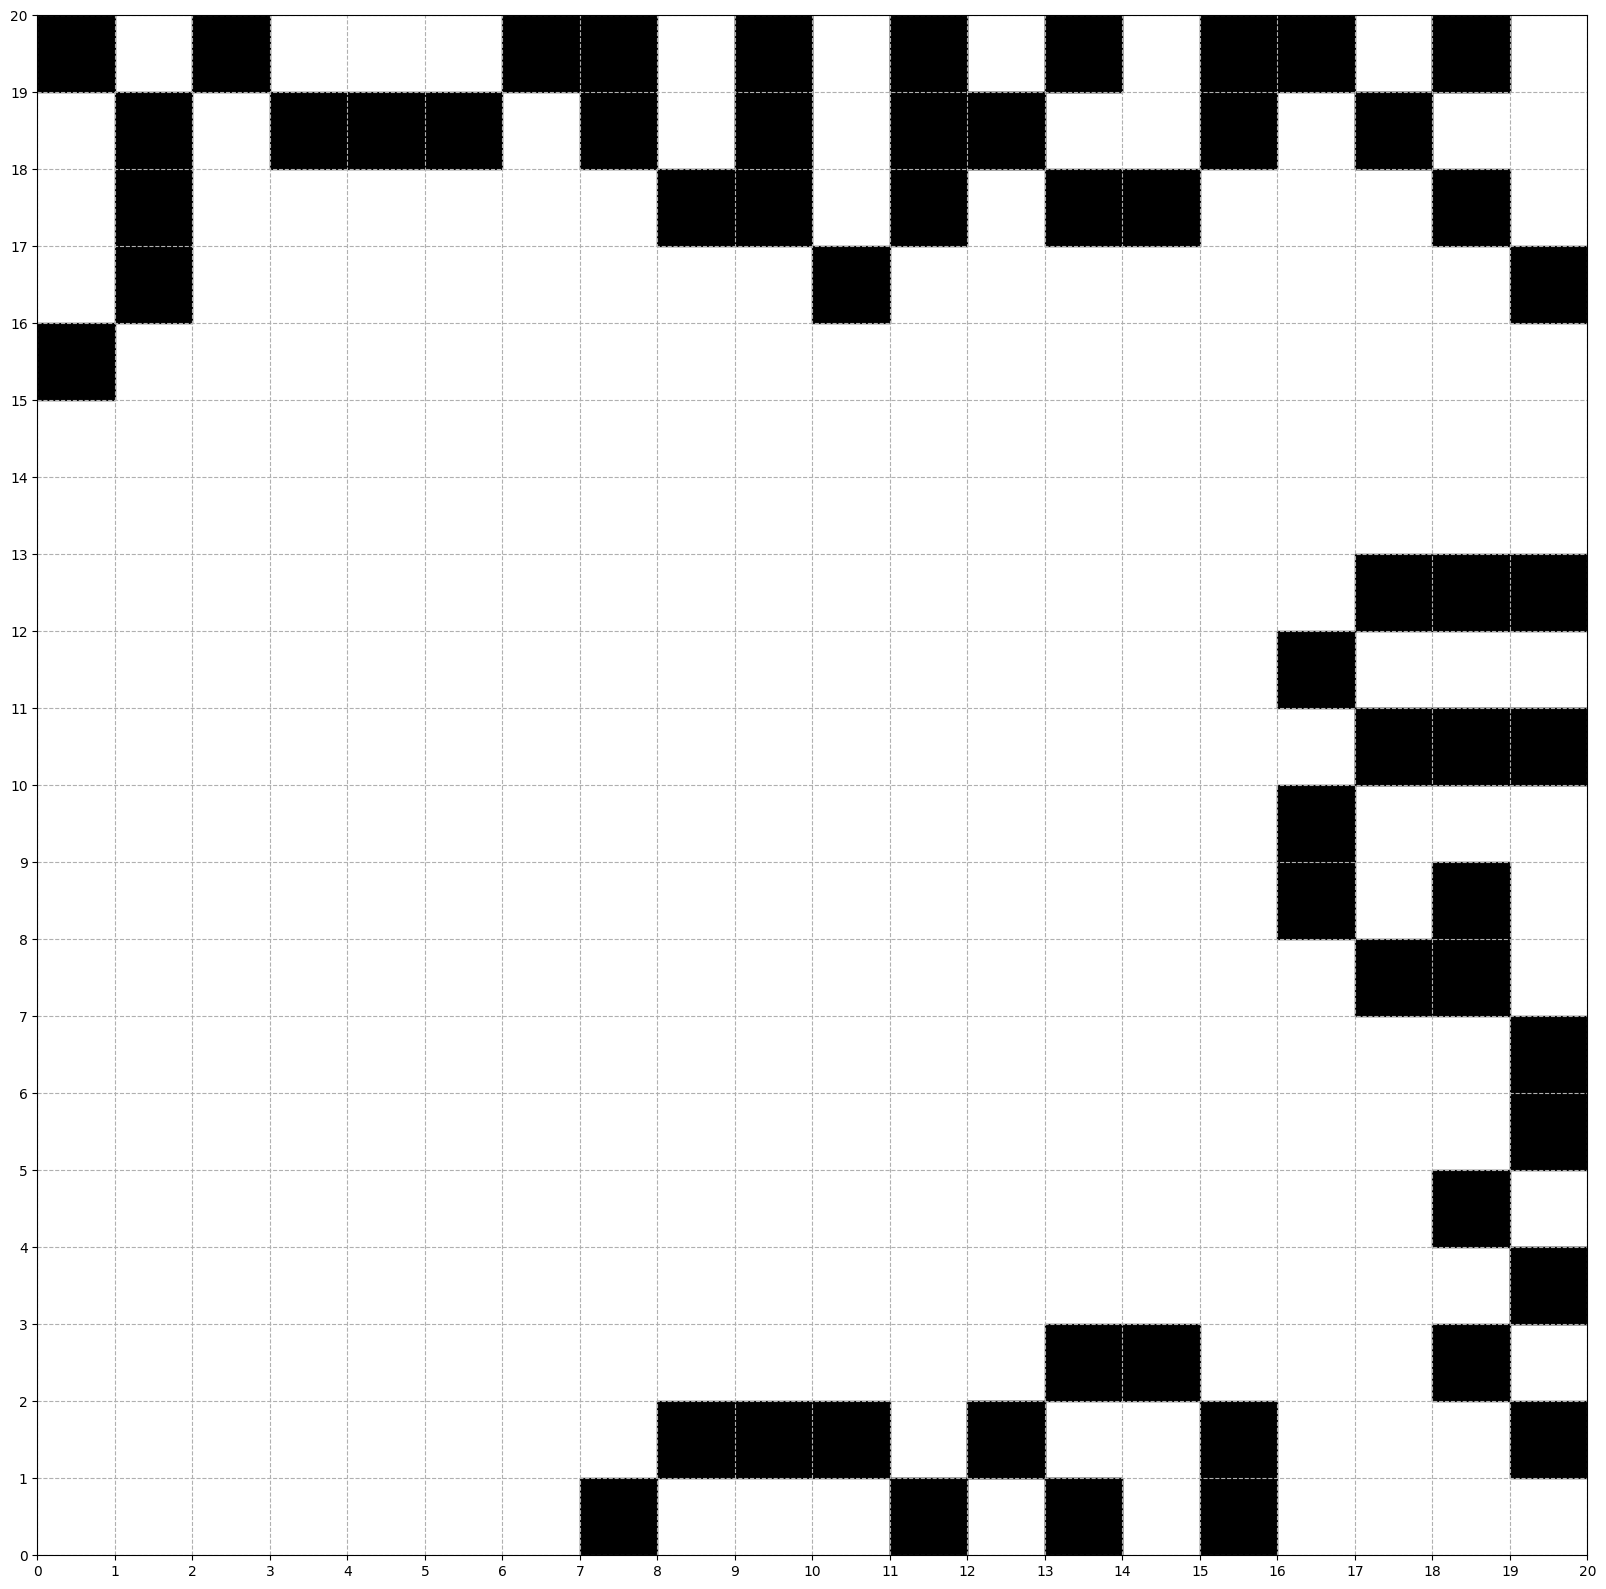

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import MultipleLocator
plt.figure(figsize = (20, 20))
ax = plt.gca()
x_major_locator = MultipleLocator(1)
y_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
# 把x/y轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim(0,20)
plt.ylim(0,20)
plt.grid(linestyle = "--")

# result_idx = random.randint(0, len(self.sol_collector.solution_list))

a = [(16, 19), (14, 19), (15, 18)] + \
    [(16, 19), (17, 18), (18, 19)] + \
        [(0, 13), (1, 12), (0, 11)] + [(1, 17), (0, 18), (0, 16)] + [(19, 13), (18, 12), (19, 11)] + [(0, 18), (3, 19), (1, 17), (2, 18)] + [(4, 0), (2, 1), (0, 0), (3, 1), (1, 1)] + [(1, 5), (1, 4), (0, 6), (0, 2), (1, 3)] + [(0, 7), (0, 9), (1, 7), (1, 9), (2, 8)] + [(19, 7), (18, 10), (18, 9), (18, 8), (19, 11)] + [(2, 14), (1, 12), (1, 15), (0, 13), (2, 13), (0, 15)] + [(17, 13), (19, 13), (18, 12), (18, 15), (19, 15), (17, 14)] + [(7, 17), (9, 19), (8, 16), (7, 19), (9, 18), (9, 17), (7, 18)] + [(1, 11), (0, 9), (3, 10), (2, 9), (2, 11), (1, 9), (0, 11)] + [(12, 17), (9, 19), (11, 16), (13, 19), (10, 16), (9, 18), (11, 18), (9, 17), (12, 18)]

for (xx, yy ) in a:
        ax.add_patch(Rectangle((yy, 19 - xx), 1, 1, color = "#000000"))
plt.show()

23


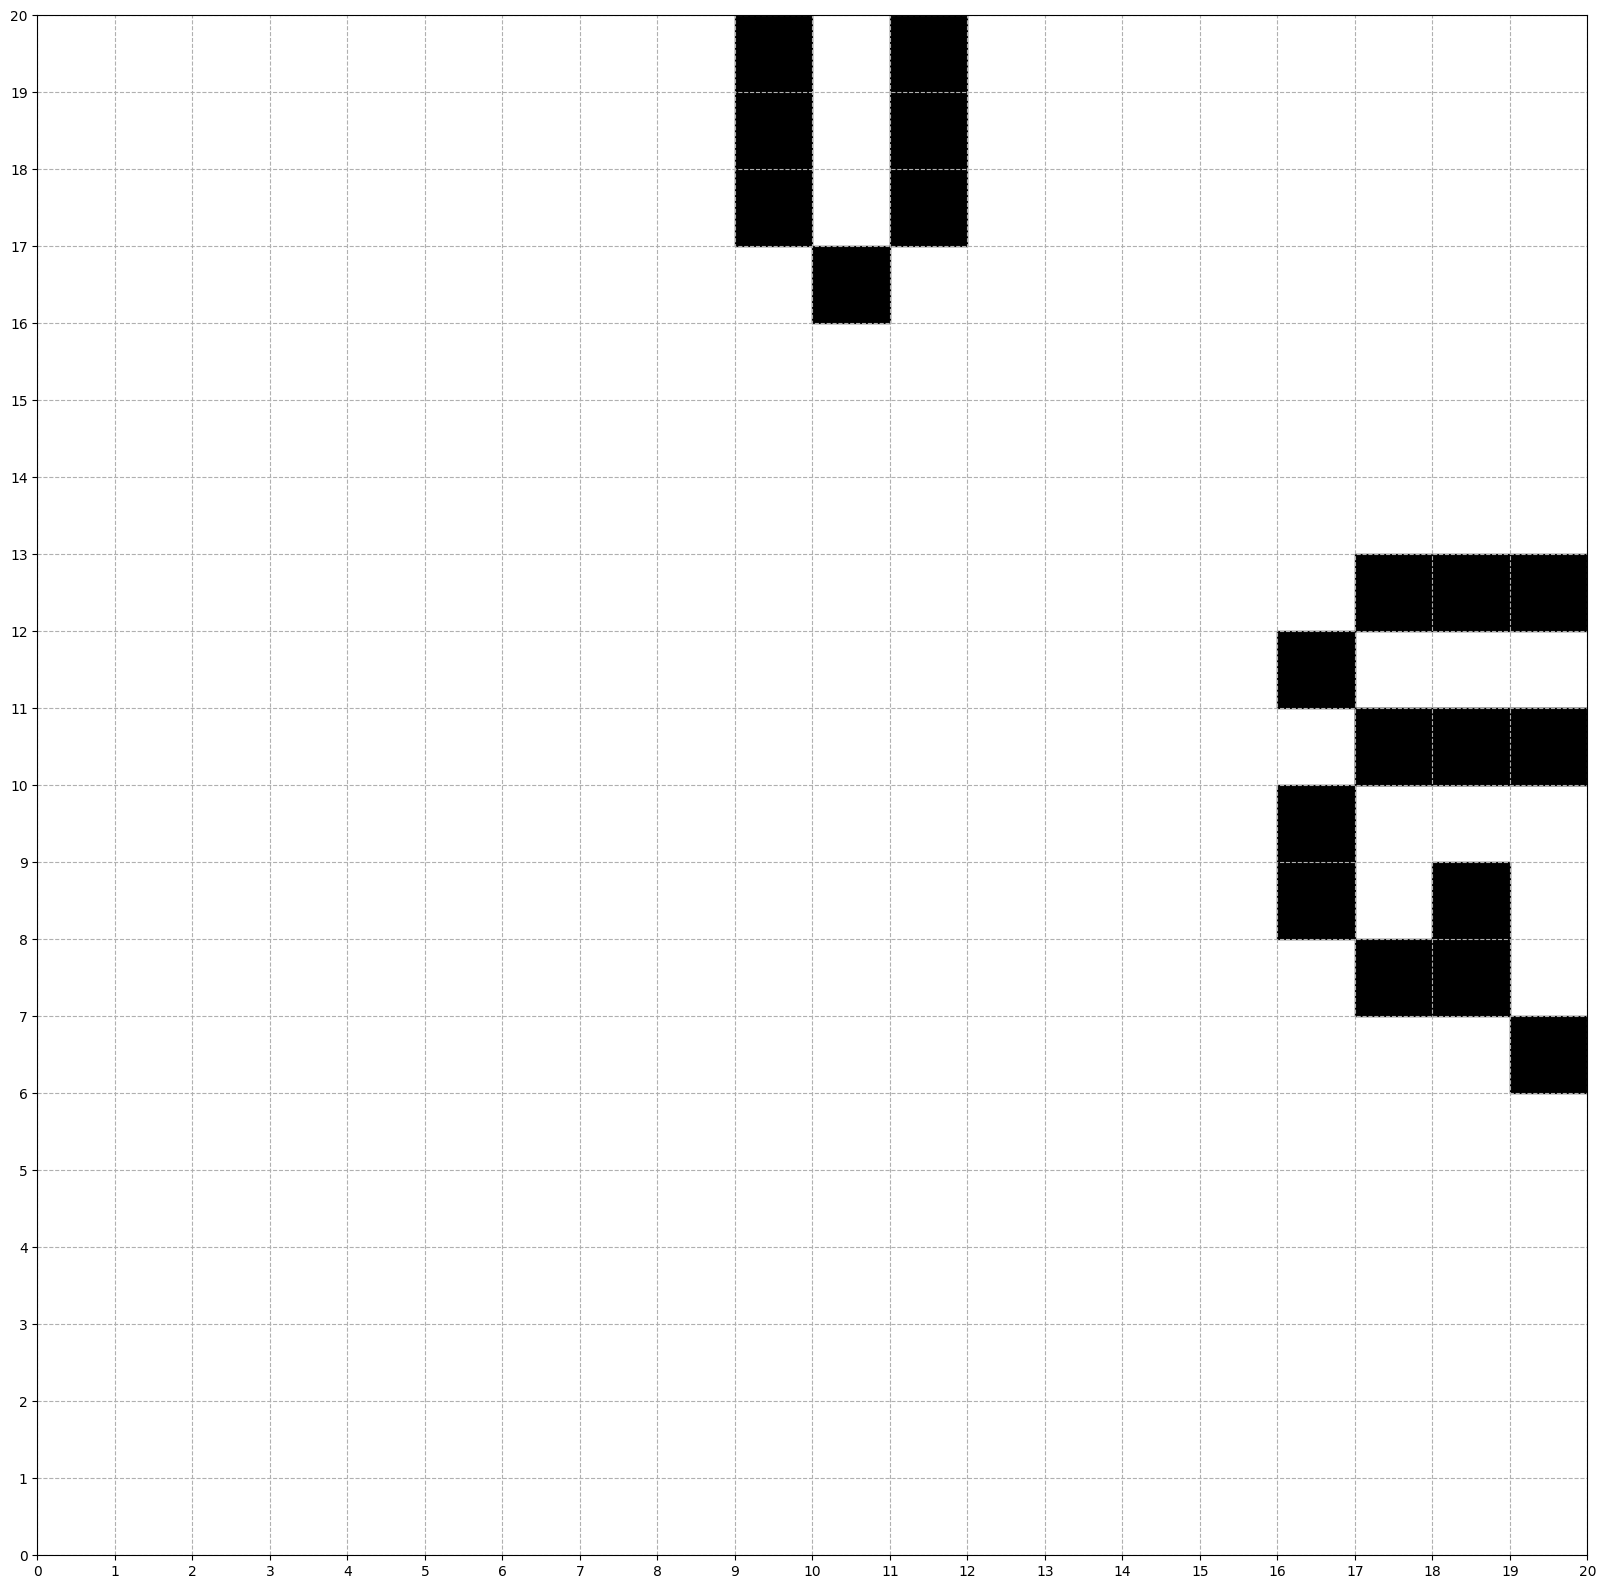

In [ ]:
import gurobipy as gp
m = gp.Model ("LP Model")
x = m.addVars(2, lb = 0.0, ub = 1.0, name = 'x')
m.addConstr(x[0] + x[1] >= 1.2, "c1")
m.addConstr(x[0] + x[1] <= 1.1, "c2")
m.addConstr(x[0] + x[1] >= 0.1, "c3")
m.setObjective(x[0] + 2*x[1])
m.optimize()
m.computeIIS()
m.write("model1.ilp")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3 rows, 2 columns and 6 nonzeros
Model fingerprint: 0x737daf1e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.300000e+00   0.000000e+00      0s

IIS computed: 2 constraints and 0 bounds
IIS runtime: 0.00 seconds (0.00 work units)


In [ ]:
a = [[(19, 18), (18, 19)],
[(12, 1), (13, 0), (11, 0)],
[(8, 19), (6, 19), (7, 18)],
[(8, 19), (9, 18), (10, 19)],
[(0, 7), (1, 6), (0, 5)],
[(19, 7), (19, 9), (18, 8)],
[(19, 18), (18, 17), (19, 16)],
[(11, 18), (12, 18), (13, 19), (10, 19)],
[(0, 8), (1, 9), (1, 10), (0, 11)],
[(18, 10), (19, 10), (18, 12), (19, 12), (17, 11)],
[(17, 13), (18, 12), (19, 12), (19, 15), (18, 14)],
[(1, 12), (1, 15), (0, 16), (1, 14), (2, 13), (0, 12)],
[(12, 4), (9, 0), (12, 1), (11, 0), (10, 4), (13, 3), (11, 5), (10, 3), (13, 2), (9, 1), (10, 2)],
[(18, 17), (16, 19), (19, 16), (18, 19), (15, 16), (16, 15), (18, 18), (17, 15), (16, 18), (19, 15), (16, 17), (18, 14)],
[(4, 0), (7, 1), (2, 1), (4, 3), (8, 1), (5, 4), (7, 0), (2, 0), (9, 2), (4, 2), (7, 3), (8, 3), (5, 0), (3, 2), (6, 3)],
[(12, 1), (16, 0), (17, 0), (16, 3), (18, 0), (13, 0), (19, 0), (14, 0), (15, 0), (17, 2), (18, 2), (13, 2), (19, 2), (14, 2), (15, 2)],
[(6, 12), (3, 16), (5, 13), (3, 19), (5, 16), (0, 17), (2, 14), (1, 15), (6, 17), (3, 18), (5, 18), (5, 15), (8, 14), (2, 16), (7, 12), (6, 16), (7, 15), (3, 14), (4, 13), (4, 19), (8, 13), (2, 18), (1, 16), (0, 18)],
[(1, 0), (0, 1)],
[(18, 0), (19, 1)],
[(19, 18), (18, 19)],
[(9, 1), (10, 0), (8, 0)],
[(8, 19), (6, 19), (7, 18)],
[(8, 19), (9, 18), (10, 19)],
[(0, 7), (1, 6), (0, 5)],
[(1, 11), (0, 12), (0, 10)],
[(19, 8), (18, 7), (19, 6)],
[(11, 18), (12, 18), (13, 19), (10, 19)],
[(3, 1), (1, 1), (3, 0), (2, 2), (1, 0)],
[(0, 19), (1, 17), (3, 19), (2, 18), (0, 17)],
[(0, 10), (1, 8), (2, 9), (1, 10), (0, 8)],
[(18, 10), (19, 10), (18, 12), (19, 12), (17, 11)],
[(1, 12), (1, 15), (0, 16), (1, 14), (2, 13), (0, 12)],
[(4, 0), (7, 1), (4, 3), (3, 1), (8, 1), (5, 4), (7, 0), (9, 2), (4, 2), (7, 3), (8, 3), (5, 0), (6, 3)],
[(12, 1), (13, 4), (14, 1), (10, 4), (12, 0), (12, 3), (14, 0), (13, 3), (10, 0), (11, 5), (10, 3), (12, 5), (14, 2), (9, 1), (10, 2)],
[(18, 17), (16, 16), (19, 17), (16, 13), (16, 19), (18, 13), (18, 19), (19, 12), (17, 12), (16, 15), (18, 18), (16, 18), (18, 15), (16, 14), (19, 15), (16, 17)],
[(1, 1), (2, 0), (0, 0)],
[(12, 1), (13, 0), (11, 0)],
[(13, 19), (11, 19), (12, 18)],
[(19, 17), (18, 18), (18, 19)],
[(0, 4), (0, 6), (1, 5)],
[(0, 19), (1, 18), (0, 17)],
[(19, 7), (19, 9), (18, 8)],
[(18, 16), (19, 15), (19, 17)],
[(8, 18), (10, 19), (9, 18), (7, 19)],
[(0, 8), (1, 9), (1, 10), (0, 11)],
[(19, 12), (18, 10), (19, 9), (18, 11)],
[(2, 14), (1, 15), (1, 11), (0, 13), (2, 13), (0, 12), (0, 15), (2, 12)],
[(12, 4), (9, 0), (12, 1), (11, 0), (10, 4), (13, 3), (11, 5), (10, 3), (13, 2), (9, 1), (10, 2)],
[(12, 1), (16, 0), (17, 0), (16, 3), (18, 0), (13, 0), (19, 0), (14, 0), (15, 0), (17, 2), (18, 2), (13, 2), (19, 2), (14, 2), (15, 2)],
[(4, 0), (7, 1), (4, 3), (8, 1), (5, 4), (7, 0), (1, 1), (9, 2), (4, 2), (7, 3), (3, 0), (2, 0), (8, 3), (5, 0), (2, 2), (3, 2), (6, 3)],
[(19, 14), (18, 17), (16, 16), (15, 14), (16, 19), (18, 16), (17, 13), (15, 13), (18, 19), (16, 12), (19, 12), (18, 12), (18, 18), (16, 18), (19, 15), (17, 14), (16, 17), (15, 15)],
[(6, 12), (6, 15), (5, 13), (3, 19), (5, 16), (8, 15), (1, 18), (2, 17), (7, 16), (6, 17), (4, 14), (3, 15), (5, 18), (8, 14), (0, 19), (7, 12), (4, 19), (3, 17), (8, 13), (1, 16), (2, 15)],
[(0, 18), (1, 19)],
[(0, 7), (1, 8), (0, 9)],
[(0, 9), (1, 10), (0, 11)],
[(18, 11), (19, 10), (19, 12)],
[(1, 1), (2, 1), (3, 0), (0, 0)],
[(19, 16), (18, 17), (18, 18), (18, 19)],
[(19, 7), (19, 10), (18, 8), (18, 9)],
[(12, 1), (11, 0), (14, 1), (14, 0), (13, 2)],
[(0, 4), (1, 4), (0, 6), (1, 6), (2, 5)],
[(2, 14), (1, 15), (0, 12), (1, 13), (0, 15)],
[(6, 18), (7, 17), (9, 19), (8, 17), (7, 19), (9, 18)],
[(2, 17), (3, 19), (1, 16), (0, 18), (3, 18), (1, 19), (0, 17)],
[(9, 19), (12, 19), (10, 16), (9, 18), (9, 17), (12, 18), (11, 17)],
[(16, 0), (14, 1), (17, 0), (16, 3), (18, 0), (19, 0), (15, 0), (17, 2), (18, 2), (19, 2), (15, 2)],
[(4, 0), (7, 1), (2, 1), (4, 3), (8, 1), (5, 4), (7, 0), (9, 2), (4, 2), (7, 3), (3, 0), (8, 3), (5, 0), (3, 2), (6, 3)],
[(18, 17), (16, 16), (16, 19), (17, 13), (19, 16), (18, 19), (18, 13), (19, 12), (16, 15), (18, 18), (16, 18), (18, 15), (16, 14), (19, 15), (16, 17)],
[(12, 4), (12, 1), (9, 5), (8, 9), (8, 6), (10, 3), (13, 2), (12, 6), (9, 1), (10, 2), (11, 7), (10, 5), (10, 8), (12, 5), (9, 0), (11, 0), (8, 7), (10, 4), (9, 9), (10, 7), (13, 3), (7, 8)],
[(17, 19), (15, 19), (16, 18)],
[(19, 18), (17, 19), (18, 18)],
[(0, 10), (0, 8), (1, 9)],
[(19, 18), (18, 17), (19, 16)],
[(11, 19), (12, 18), (13, 18), (14, 19)],
[(0, 3), (0, 6), (1, 4), (1, 5)],
[(0, 0), (3, 1), (1, 1), (3, 0), (2, 2)],
[(7, 1), (7, 0), (10, 0), (8, 2), (9, 1)],
[(1, 18), (2, 17), (0, 16), (1, 16), (0, 18)],
[(19, 7), (18, 10), (18, 9), (19, 12), (18, 11), (18, 8)],
[(9, 19), (11, 19), (10, 16), (9, 18), (9, 17), (12, 18), (11, 17)],
[(7, 17), (9, 19), (7, 16), (7, 19), (9, 15), (10, 16), (9, 18), (9, 17), (8, 15), (7, 18)],
[(4, 0), (7, 1), (4, 3), (3, 1), (5, 4), (7, 0), (4, 2), (7, 3), (5, 0), (8, 2), (6, 3)],
[(12, 4), (12, 1), (10, 4), (12, 0), (13, 3), (10, 0), (11, 5), (10, 3), (13, 2), (9, 1), (10, 2)],
[(12, 1), (16, 0), (17, 0), (16, 3), (18, 0), (13, 0), (19, 0), (14, 0), (19, 3), (15, 0), (17, 2), (18, 2), (13, 2), (14, 2), (15, 2)],
[(19, 14), (18, 17), (16, 18), (16, 16), (15, 14), (18, 16), (17, 13), (17, 19), (15, 13), (16, 12), (18, 12), (18, 18), (19, 12), (19, 15), (17, 14), (16, 17), (15, 15)],
[(6, 12), (6, 15), (5, 13), (3, 19), (5, 16), (8, 15), (1, 18), (2, 17), (7, 16), (6, 17), (4, 14), (3, 15), (5, 18), (8, 14), (7, 12), (4, 19), (3, 17), (8, 13), (1, 16), (0, 18), (2, 15)],
[(6, 12), (4, 12), (3, 10), (5, 13), (1, 9), (2, 14), (1, 15), (6, 11), (3, 9), (4, 8), (3, 12), (0, 10), (0, 13), (2, 10), (2, 13), (7, 9), (4, 10), (5, 8), (8, 10), (0, 12), (0, 15), (2, 12), (7, 11), (6, 9)],
[(16, 19), (14, 19), (15, 18)],
[(1, 17), (0, 18), (0, 16)],
[(0, 18), (3, 19), (1, 17), (2, 18)],
[(4, 0), (2, 1), (0, 0), (3, 1), (1, 1)],
[(1, 5), (1, 4), (0, 6), (0, 2), (1, 3)],
[(0, 7), (0, 9), (1, 7), (1, 9), (2, 8)],
[(1, 11), (2, 10), (0, 9), (1, 9), (0, 11)],
[(17, 17), (16, 19), (18, 19), (18, 18), (15, 18), (16, 17)],
[(7, 17), (9, 19), (8, 16), (7, 19), (9, 18), (9, 17), (7, 18)],
[(2, 14), (1, 15), (1, 11), (0, 13), (2, 13), (0, 15), (2, 12), (0, 11)],
[(12, 17), (9, 19), (11, 16), (13, 19), (10, 16), (9, 18), (11, 18), (9, 17), (12, 18)],
[(4, 0), (4, 3), (3, 1), (8, 1), (7, 0), (6, 4), (9, 2), (7, 3), (8, 3), (6, 0), (5, 3), (3, 2)],
[(17, 17), (16, 16), (15, 14), (17, 13), (19, 16), (18, 19), (15, 13), (16, 12), (18, 18), (18, 15), (17, 14), (15, 15)],
[(16, 0), (13, 1), (17, 0), (16, 3), (18, 0), (19, 0), (14, 0), (15, 0), (17, 2), (18, 2), (19, 2), (14, 2), (15, 2)],
[(18, 4), (16, 11), (17, 14), (18, 7), (18, 15), (17, 13), (18, 9), (17, 6), (15, 10), (16, 8), (18, 12), (15, 9), (17, 5), (17, 11), (19, 15), (17, 8), (19, 5), (18, 8)],
[(12, 4), (12, 7), (8, 6), (10, 3), (13, 8), (15, 5), (14, 0), (12, 6), (9, 1), (10, 2), (9, 4), (11, 7), (13, 4), (13, 1), (15, 7), (16, 6), (12, 2), (14, 5), (9, 0), (14, 8), (8, 4), (11, 0), (10, 4), (9, 6), (10, 7), (13, 3), (7, 5)],
[(19, 13), (18, 12), (19, 11)],
[(12, 1), (14, 0), (13, 1), (11, 0)],
[(1, 18), (2, 17), (3, 19), (0, 18), (3, 18)],
[(19, 7), (18, 10), (18, 9), (18, 8), (19, 11)],
[(2, 1), (0, 0), (3, 1), (1, 1), (5, 0), (4, 1)],
[(2, 14), (1, 12), (1, 15), (2, 13), (0, 12), (0, 14)],
[(1, 18), (2, 17), (1, 15), (1, 16), (0, 18), (0, 14)],
[(17, 13), (19, 13), (18, 12), (18, 15), (19, 15), (17, 14)],
[(17, 17), (18, 17), (17, 19), (15, 19), (19, 18), (15, 18), (16, 17)],
[(1, 11), (0, 9), (3, 10), (2, 9), (2, 11), (1, 9), (0, 11)],
[(7, 1), (4, 3), (7, 0), (6, 4), (7, 3), (5, 0), (7, 2), (5, 3), (3, 2), (4, 1)],
[(4, 4), (0, 4), (4, 3), (0, 6), (2, 3), (1, 6), (3, 2), (2, 5), (1, 3), (3, 5)],
[(17, 17), (18, 17), (16, 16), (19, 17), (15, 14), (17, 13), (15, 13), (16, 12), (18, 15), (19, 15), (17, 14), (15, 15)],
[(16, 0), (13, 1), (17, 0), (16, 3), (18, 0), (19, 0), (14, 0), (15, 0), (14, 3), (17, 2), (18, 2), (13, 2), (19, 2), (15, 2)],
[(12, 4), (11, 7), (9, 0), (12, 1), (10, 5), (11, 0), (10, 4), (9, 6), (10, 7), (13, 3), (12, 6), (10, 3), (13, 2), (12, 5), (9, 1), (10, 2)],
[(12, 17), (7, 17), (9, 19), (11, 14), (7, 16), (13, 16), (12, 19), (7, 19), (9, 15), (10, 13), (9, 18), (9, 14), (12, 15), (12, 18), (9, 17), (8, 15), (7, 18), (11, 17)],
[(0, 7), (3, 8), (5, 5), (5, 8), (8, 7), (4, 6), (0, 9), (6, 4), (6, 7), (2, 6), (4, 8), (8, 6), (7, 8), (1, 6), (7, 5), (1, 9), (3, 5), (2, 8)]]


In [ ]:
def CreekSolver(m, n, grid) :
    """_summary_

    Args:
        m (_type_): 行数
        n (_type_): 列数
        grid (_type_): 网格
    """
    
    Creek = gp.Model("Creek")
    Creek.modelSense = gp.GRB.MAXIMIZE
    # Creek.Params.lazyConstraints = 1
    Creek.update()
    x = {}
    for i in range(m):
        for j in range(n):
            x[i, j] = Creek.addVar(
            vtype = gp.GRB.BINARY,
            obj = 1,
            name = f"x[{i},{j}]")
            
    for i in range(m + 1):
        for j in range(n + 1):
            if grid[i][j] != ".":
                neighbours = []
                directions = [(-1, -1), (-1, 0), (0, -1), (0, 0)]
                for (subx, suby) in directions:
                    if (i + subx >= 0 and i + subx < m) and (j + suby >= 0 and j + suby < n):
                        neighbours.append((i + subx, j + suby))
                Creek.addConstr(gp.quicksum(x[subx, suby] for (subx, suby) in neighbours) == int(grid[i][j]), name = f"constr_{i}_{j}_{grid[i][j]}")

    for idxa, k in enumerate(a):
        Creek.addConstr(gp.quicksum(x[xx, yy] for (xx, yy) in k) <= len(k) - 1,  name = f"a_{idxa}")
    Creek.setObjective(gp.quicksum(x[i, j] for i in range(m) for j in range(n) ), gp.GRB.MAXIMIZE)
    # Creek.setObjective(10, gp.GRB.MAXIMIZE)
    
    
    Creek.optimize()
    Creek.write("Creek.lp")
    Creek.computeIIS()
    Creek.write("Creek.ilp")
    
    
    for i in range(m):
        for j in range(n):
            if x[i, j].x > 1e-6:
                print(f"X", end = " ")
            else:
                print(f".", end = " ")
        print()
    print()

    
if __name__ == "__main__":
    m, n, grid = readGrid("20x20_1")
    CreekSolver(m, n, grid)
    

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 275 rows, 400 columns and 1501 nonzeros
Model fingerprint: 0xd22f2f9f
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 159 rows and 264 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -

Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
----------------------------------

AttributeError: Unable to retrieve attribute 'x'